
<center>
<font color="cyan"><h2 >Map Reduce</h2></font>
</center>

<center>
<h3> Using <strong>Send API</strong> to execute parallely</h3>
</center>




In [1]:
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated,List
from IPython.display import display,Image
from pydantic import BaseModel, Field
from random import randint
import operator
load_dotenv()
llm = ChatOpenAI(model='gpt-4o-mini')


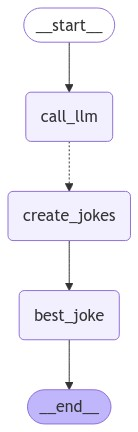

In [14]:
# models
class Subject(BaseModel):
    subjects : List[str]

class Joke(BaseModel):
    joke : List[str]

# graph states
class State(TypedDict):
    topic : str
    subjects : List[str]
    jokes: Annotated[list[str],operator.add]
    bestJoke : str

class JokeState(TypedDict):
    subject : str
# nodes
def call_llm(state: State):
    prompt = f"Create Less than 5 more than 3 related subjects to this topic `{state['topic']}` .  "
    response = llm.with_structured_output(Subject).invoke(prompt)
    return {'subjects':response.subjects}

def create_jokes(state:JokeState): # Getting state from continue_creating_joke
    prompt = f"create one joke on this subject : {state['subject']}"
    response = llm.with_structured_output(Joke).invoke(prompt)
    print('*'*20,'response : ',response,'*'*20)
    return {'jokes':[response.joke]} # writing to graph states

def continue_creating_joke(state):
    return [Send('create_jokes',{'subject' : s}) for s in state['subjects']]

def best_joke(state):
    total_jokes = len(state['jokes'])
    best_joke_index = randint(0,total_jokes-1)
    bestJokequetion = state['jokes'][best_joke_index]
    return {'bestJoke': bestJokequetion }




#builder
builder = StateGraph(State)
builder.add_node('call_llm',call_llm)
builder.add_node('create_jokes',create_jokes)
builder.add_node('best_joke',best_joke)

builder.add_edge(START,'call_llm')
builder.add_conditional_edges('call_llm',continue_creating_joke,['create_jokes'])
builder.add_edge('create_jokes','best_joke')
builder.add_edge('best_joke',END)

graph = builder.compile()

# graphcompile
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({'topic':'cat'})

******************** response :  joke=['Why did the cat sit on the computer?', 'Because it wanted to keep an eye on the mouse!'] ********************
******************** response :  joke=['Why did the cat go to the vet?', 'Because it was feeling a little paw-sitive, but needed a check-up to be sure!'] ********************
******************** response :  joke=['Why did the Siamese cat always get invited to parties?', 'Because it was always the life of the purr-ty!'] ********************
******************** response :  joke=['Why did the cat sit on the computer?', 'Because it wanted to keep an eye on the mouse!'] ********************
******************** response :  joke=['Why did the cat join the training class?', 'Because it wanted to master the art of purr-suasion!'] ********************


{'topic': 'cat',
 'subjects': ['feline behavior',
  'cat breeds',
  'cat health',
  'cat care',
  'cat training'],
 'jokes': [['Why did the cat sit on the computer?',
   'Because it wanted to keep an eye on the mouse!'],
  ['Why did the Siamese cat always get invited to parties?',
   'Because it was always the life of the purr-ty!'],
  ['Why did the cat go to the vet?',
   'Because it was feeling a little paw-sitive, but needed a check-up to be sure!'],
  ['Why did the cat sit on the computer?',
   'Because it wanted to keep an eye on the mouse!'],
  ['Why did the cat join the training class?',
   'Because it wanted to master the art of purr-suasion!']],
 'bestJoke': ['Why did the cat sit on the computer?',
  'Because it wanted to keep an eye on the mouse!']}